# Vehicle Detection

## Imports

In [1]:
import os
import glob
import cv2
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# kill axis in rcParams
#print(mpl.rcParams.keys())
mpl.rc('image', interpolation='bilinear')
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
# enlarge default figure size
mpl.rc('figure', figsize=(10, 5))

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score

## Constants

In [2]:
# directory for output images
OUT_DIR = "output_images"

# directory with test images
IN_DIR = "test_images"

## All Lesson Functions

In [180]:
# HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# extract features from a list of images
def extract_features(imgs, hist_bins, orient, pix_per_cell, cell_per_block):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion to YUV
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        

        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# update heatmap with a list of detections from the current level
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# threshold the heatmap to get rid of weak detections
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# perform filtered heatmap segmentation into object labels
def connected_components(filteredHeatmap):
    return label(filteredHeatmap)

# visualize segmented objects using bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 6)
    # Return the image
    return img

## Training the Classifier

### Load Dataset

In [4]:
paths0 = glob.glob('./non-vehicles/**/*.png', recursive=True)
paths1 = glob.glob('./vehicles/**/*.png', recursive=True)

In [5]:
# Experimentally discovered, proven computationally optimal
HOG_ORIENT = 8
HOG_CELL_PER_BLOCK = 2
HOG_PIX_PER_CELL = 8
COLOR_HIST_BINS = 16

In [6]:
features0 = extract_features(paths0, COLOR_HIST_BINS, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK)
features1 = extract_features(paths1, COLOR_HIST_BINS, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK)

In [7]:
X = np.asarray(features0 + features1, np.float64)
y = np.zeros((len(features0) + len(features1), 1))
y[len(features0):,0] = 1

In [8]:
print('Loaded {} cars and {} non-cars'.format(len(features1), len(features0)))
print('Feature vector shape {}'.format(X.shape))

Loaded 8792 cars and 8968 non-cars
Feature vector shape (17760, 4752)


In [9]:
#rand_state = np.random.randint(0, 100)
rand_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [10]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
print(X_train.shape)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

(14208, 4752)


### Example of HOG features visualization

In [155]:
def visualizeHogFeatures():
    img = cv2.imread(paths1[700])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, vis = get_hog_features(img, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK, vis=True)
    vis = vis * 255
    plt.imshow(np.hstack((img, vis)), cmap='gray')

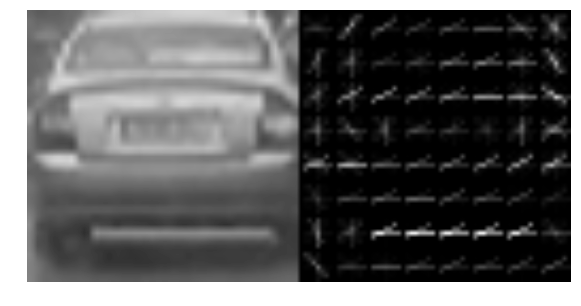

In [156]:
visualizeHogFeatures()

### Train the Classifier

In [12]:
param_grid = [
  {'C': [0.1, 1.0, 10.0], 'kernel': ['linear']},
  {'C': [0.1, 1.0, 10.0], 'kernel': ['rbf'], 'gamma': [0.1, 1.0, 10.0]},
 ]
svr = svm.SVC()
clf = GridSearchCV(svr, param_grid, cv=2, n_jobs=-1, verbose=99)
clf.fit(scaled_X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Memmaping (shape=(14208, 4752), dtype=float64) to new file /var/folders/g5/dymnp15x1ps0b3tr21vfq0dw0000gn/T/joblib_memmaping_pool_2888_4580031848/2888-4994432024-fc4a5b9b0822a4d7596f0e3f781886c2.pkl
[CV] C=0.1, kernel=linear ............................................
Pickling array (shape=(14208, 1), dtype=float64).
Pickling array (shape=(7104,), dtype=int64).
Pickling array (shape=(7104,), dtype=int64).
[CV] C=0.1, kernel=linear ............................................
Memmaping (shape=(14208, 4752), dtype=float64) to old file /var/folders/g5/dymnp15x1ps0b3tr21vfq0dw0000gn/T/joblib_memmaping_pool_2888_4580031848/2888-4994432024-fc4a5b9b0822a4d7596f0e3f781886c2.pkl
Pickling array (shape=(14208, 1), dtype=float64).
Pickling array (shape=(7104,), dtype=int64).
Pickling array (shape=(7104,), dtype=int64).
[CV] C=1.0, kernel=linear ............................................
Memmaping (shape=(14208, 4752), dtype=float64) t

Memmaping (shape=(14208, 4752), dtype=float64) to old file /var/folders/g5/dymnp15x1ps0b3tr21vfq0dw0000gn/T/joblib_memmaping_pool_2888_4580031848/2888-4994432024-fc4a5b9b0822a4d7596f0e3f781886c2.pkl
Pickling array (shape=(14208, 1), dtype=float64).
Pickling array (shape=(7104,), dtype=int64).
Pickling array (shape=(7104,), dtype=int64).
[CV]  C=0.1, kernel=rbf, gamma=1.0, score=0.5077421171171171, total=25.2min
[CV] C=1.0, kernel=rbf, gamma=10.0 ...................................
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed: 40.9min remaining: 57.3min
Memmaping (shape=(14208, 4752), dtype=float64) to old file /var/folders/g5/dymnp15x1ps0b3tr21vfq0dw0000gn/T/joblib_memmaping_pool_2888_4580031848/2888-4994432024-fc4a5b9b0822a4d7596f0e3f781886c2.pkl
Pickling array (shape=(14208, 1), dtype=float64).
Pickling array (shape=(7104,), dtype=int64).
Pickling array (shape=(7104,), dtype=int64).
[CV]  C=0.1, kernel=rbf, gamma=10.0, score=0.5077421171171171, total=25.2min
[CV] C=10.0, kern

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 1.0, 10.0], 'kernel': ['linear']}, {'C': [0.1, 1.0, 10.0], 'kernel': ['rbf'], 'gamma': [0.1, 1.0, 10.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=99)

In [13]:
print(clf.best_params_, ' -> score=', clf.best_score_)
joblib.dump(clf.best_estimator_, 'svm_car.pkl')

{'C': 0.1, 'kernel': 'linear'}  -> score= 0.98852759009


['svm_car.pkl']

### Check score on test set

In [14]:
carSvm = joblib.load('svm_car.pkl')

In [15]:
y_test_pred = carSvm.predict(scaled_X_test)
testScore = accuracy_score(y_test, y_test_pred)
print('SVM test score = ', testScore)

SVM test score =  0.990990990991


## Image Pipeline

### Single scale detector

In [47]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(imgBgr, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, hist_bins, bVis=False):
    imgDraw = None
    if bVis:
        imgDraw = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2RGB)

    imgRoi = imgBgr[ystart:ystop,:,:]
    
    if scale != 1:
        imgRoi = cv2.resize(imgRoi, (np.int(imgRoi.shape[1]/scale), np.int(imgRoi.shape[0]/scale)), interpolation=cv2.INTER_AREA)

    imgRoi = cv2.cvtColor(imgRoi, cv2.COLOR_BGR2YUV)
        
    ch1 = imgRoi[:,:,0]
    ch2 = imgRoi[:,:,1]
    ch3 = imgRoi[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    wnds = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract HOG features for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).ravel()

            # Extract the image patch
            subimg = imgRoi[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            hist_features = color_hist(subimg, nbins=hist_bins).ravel()

            # combine partial features into a feature vector
            features = []
            features.append(hist_features)
            features.append(hog_features)
            features = np.concatenate(features).reshape(1,-1)
            features = np.asarray(features, np.float64)
            
            # Scale features and make a prediction
            features = X_scaler.transform(features)    

            test_prediction = svc.predict(features)
                        
            if test_prediction == 1:
                wnd_xbox_left = np.int(xleft*scale)
                wnd_ytop_draw = np.int(ytop*scale)
                wnd_sz = np.int(window*scale)

                wnd = ((wnd_xbox_left, wnd_ytop_draw+ystart), (wnd_xbox_left+wnd_sz,wnd_ytop_draw+wnd_sz+ystart))
                wnds.append(wnd)

                if bVis:
                    cv2.rectangle(imgDraw, wnd[0], wnd[1], (0,255,0), 6)
             
    if bVis:
        return wnds, imgDraw
    else:
        return wnds

In [113]:
# These constants were chosen by observing visualizeScaleAndExtraction function results 
# on a series of cars at increasing distance
SCALE_POW_SAMPLES = 4
SCALE_FACTOR = 1.4
Y_START_STOP = [
    (400, 520),
    (380, 560),
    (380, 620),
    (380, 680)
]

In [98]:
def visualizeScaleAndExtraction():
    listImages = glob.glob(IN_DIR + '/dist*.png')
    print(listImages)
    
    f, axarr = plt.subplots(len(listImages), SCALE_POW_SAMPLES, figsize=(15, 15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)

        for scalePow in range(SCALE_POW_SAMPLES):
            scale = np.power(SCALE_FACTOR, scalePow)
            
            _, imgRects = find_cars(img, Y_START_STOP[scalePow][0], Y_START_STOP[scalePow][1], scale, carSvm, X_scaler, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK, COLOR_HIST_BINS, True)
            cv2.line(imgRects, (0, Y_START_STOP[scalePow][0]), (imgRects.shape[1], Y_START_STOP[scalePow][0]), color=(255,0,0), thickness=6)
            cv2.line(imgRects, (0, Y_START_STOP[scalePow][1]), (imgRects.shape[1], Y_START_STOP[scalePow][1]), color=(255,0,0), thickness=6)

            axarr[i].imshow(imgRects)
            axarr[i].set_title('scale={}'.format(scale))

            i += 1
        #break
    f.tight_layout()

['test_images/dist1.png', 'test_images/dist2.png', 'test_images/dist3.png', 'test_images/dist4.png', 'test_images/dist5.png', 'test_images/dist6.png']


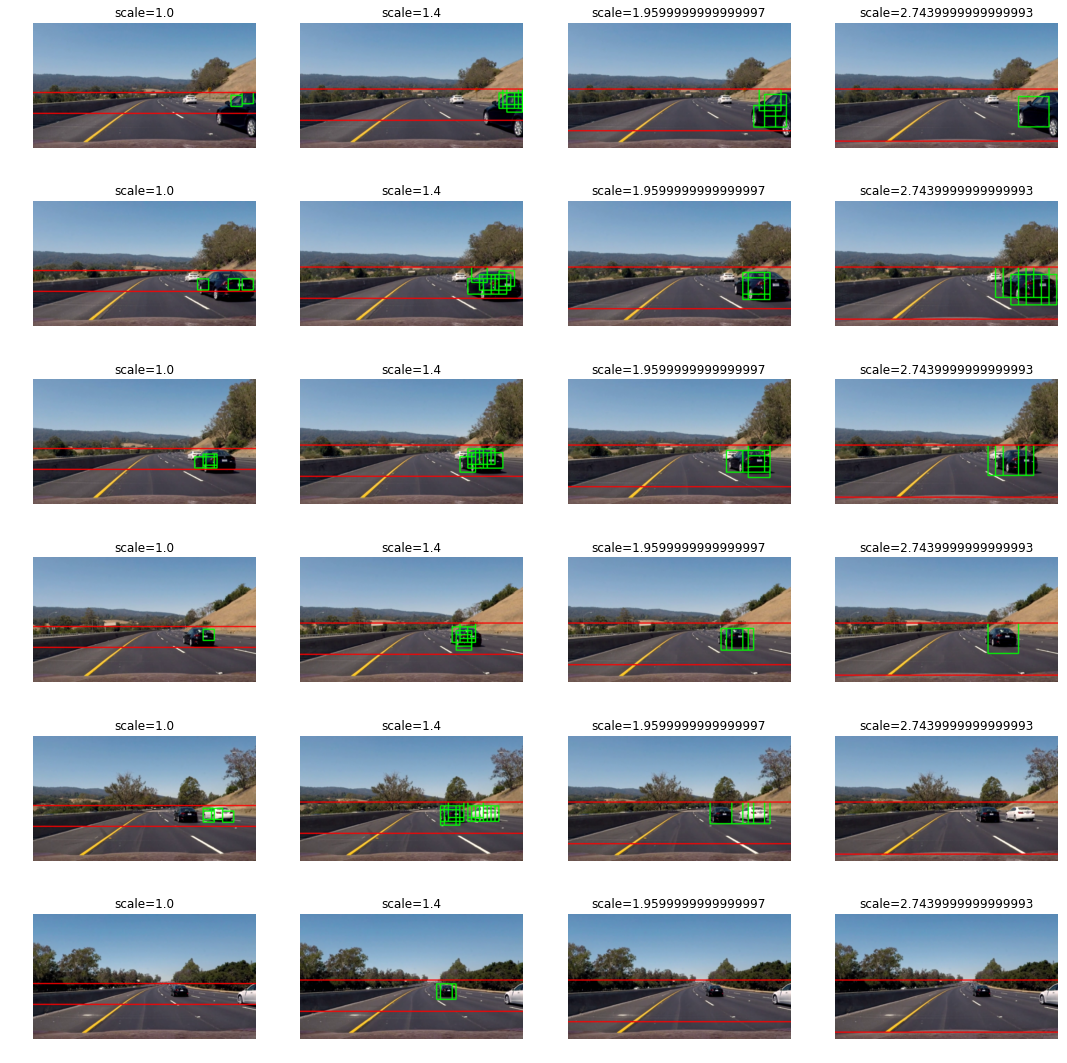

In [99]:
visualizeScaleAndExtraction()

### Multi-scale detector

In [162]:
def findCarsMultiscale_720p(img, bVis=False):
    assert img.shape[0] == 720 and img.shape[1] == 1280
    allWnds = []
    for scalePow in range(SCALE_POW_SAMPLES):
        scale = np.power(SCALE_FACTOR, scalePow)            
        wnds = find_cars(img, Y_START_STOP[scalePow][0], Y_START_STOP[scalePow][1], scale, carSvm, X_scaler, 
                         HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELL_PER_BLOCK, COLOR_HIST_BINS, False)
        allWnds += wnds
    if bVis:
        return allWnds, draw_boxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), allWnds)
    else:
        return allWnds

In [124]:
def visualizeMultiscaleBoxes():
    listImages = glob.glob(IN_DIR + '/dist*.png')
    
    f, axarr = plt.subplots((len(listImages)+2)//3, 3, figsize=(15, 5))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)

        _, imgRects = findCarsMultiscale_720p(img, True)
        axarr[i].imshow(imgRects)
        axarr[i].set_title(fname)

        i += 1
    f.tight_layout()

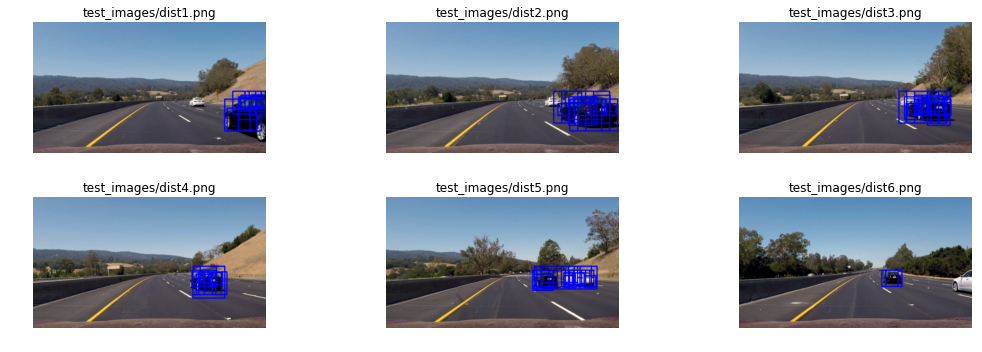

In [125]:
visualizeMultiscaleBoxes()

### Heatmap

In [179]:
def convertWndsToHeatmap(img, wnds):
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    add_heat(heatmap, wnds)
    return heatmap

In [238]:
def visualizeHeatmap():
    img = cv2.imread(IN_DIR + '/dist5.png')
    wnds = findCarsMultiscale_720p(img)
    heatmap = apply_threshold(heatmap, 2)
    heatmap = convertWndsToHeatmap(img, wnds)
    plt.imshow(heatmap, cmap='hot')

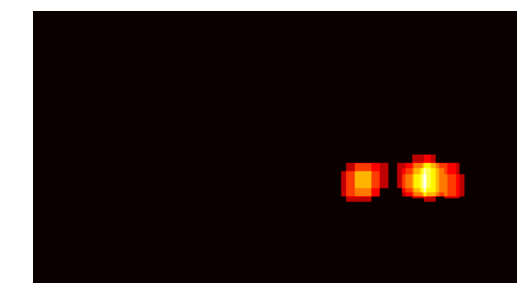

In [239]:
visualizeHeatmap()

### Label cars

In [197]:
def getFinalCarRects(img, heatmap):
    labels = connected_components(heatmap)
    return draw_labeled_bboxes(img, labels)

In [198]:
def visualizeCarLabels():
    img = cv2.imread(IN_DIR + '/dist5.png')
    wnds = findCarsMultiscale_720p(img)
    heatmap = convertWndsToHeatmap(img, wnds)
    heatmap = apply_threshold(heatmap, 2)
    vis = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), heatmap)
    plt.imshow(vis)

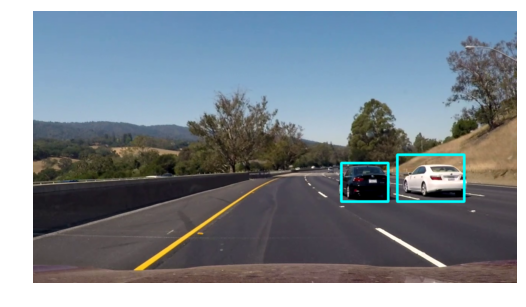

In [199]:
visualizeCarLabels()

### All steps together

In [240]:
def processImage(img):
    wnds, imgRects = findCarsMultiscale_720p(img, True)
    imgHeatmap = convertWndsToHeatmap(img, wnds)
    imgHeatmap = apply_threshold(imgHeatmap, 2)
    imgFinal = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imgHeatmap)
    imgHeatmap = cv2.resize(imgHeatmap, (imgHeatmap.shape[1]//2, imgHeatmap.shape[0]//2), cv2.INTER_AREA)
    #print(imgHeatmap.dtype, imgHeatmap.shape, np.amax(imgHeatmap), imgHeatmap)

    import matplotlib.cm as cm
    imgHeatmap = (255 * cm.hot(imgHeatmap.astype(np.float) / np.amax(imgHeatmap))[:,:,0:3]).astype(np.uint8)
    
    imgFinal[0:imgHeatmap.shape[0], 0:imgHeatmap.shape[1], :] = imgHeatmap[:,:,:]
    return imgFinal

In [247]:
def processImages():
    listImages = glob.glob(IN_DIR + '/*')
    
    f, axarr = plt.subplots((len(listImages)+2)//3, 3, figsize=(15, 15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = cv2.imread(fname)
        img = processImage(img)
        
        axarr[i].imshow(img)
        axarr[i].set_title(fname)

        i += 1
    f.tight_layout()

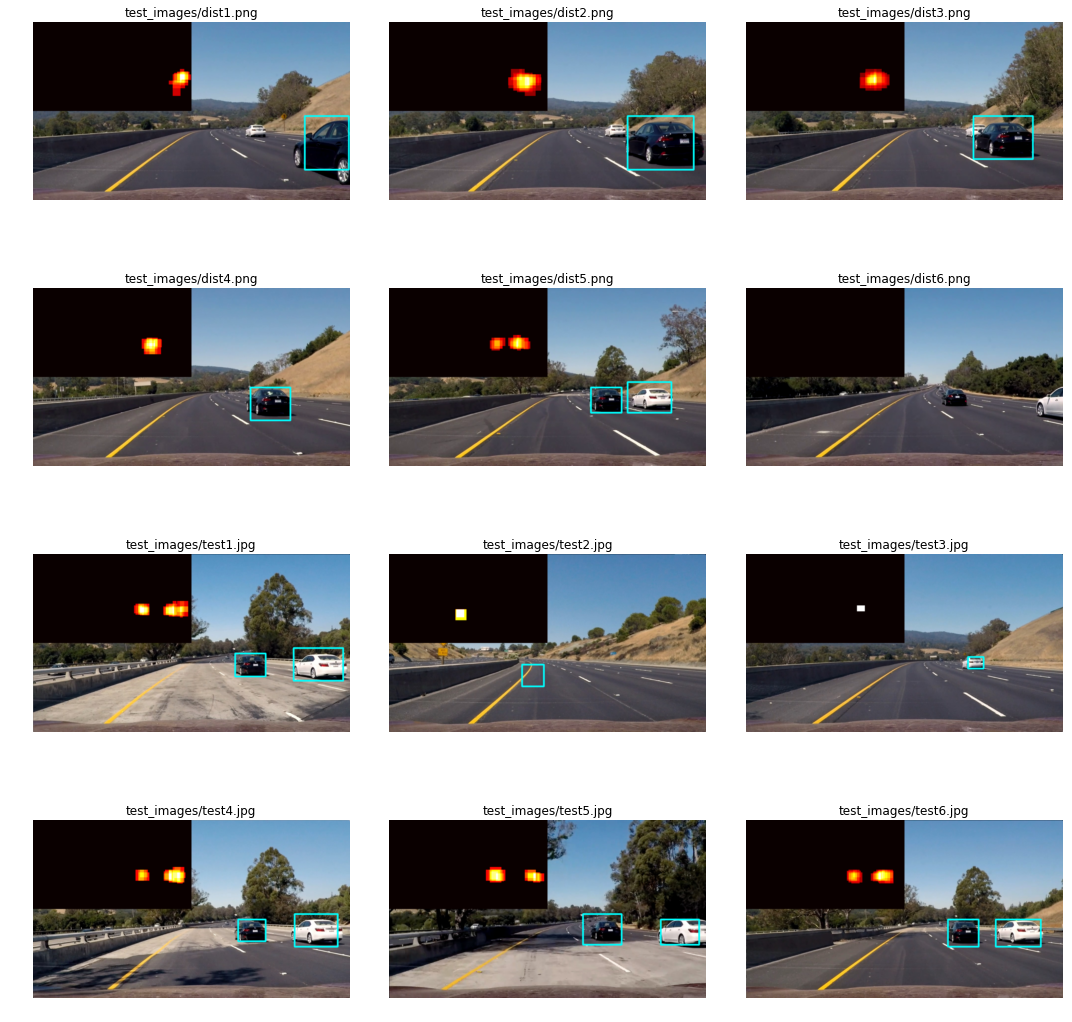

In [248]:
processImages()

## Video pipeline

In [259]:
def processVideo(nameIn, nameOut, startSec=None, endSec=None):
    vin = cv2.VideoCapture(nameIn)
    fps = vin.get(cv2.CAP_PROP_FPS)
    vout = None
    
    i = -1

    heatmapAcc = None
    
    while(vin.isOpened()):
        i += 1
        ret, img = vin.read()
        if not ret:
            break

        if heatmapAcc is None:
            heatmapAcc = np.zeros((img.shape[0], img.shape[1]), dtype=np.float)
            
        if startSec is not None:
            if i < startSec * fps:
                continue
            if endSec is not None:
                if i > endSec * fps:
                    continue
            
        if vout == None and nameOut != None:
            outDims = (img.shape[1], img.shape[0])
            vout = cv2.VideoWriter(nameOut, cv2.VideoWriter_fourcc(*'XVID'), fps, outDims, True)

        wnds, imgRects = findCarsMultiscale_720p(img, True)
        imgHeatmap = convertWndsToHeatmap(img, wnds)
        
        heatmapAcc = heatmapAcc * 0.7 + imgHeatmap * 0.3
        imgHeatmap = apply_threshold(heatmapAcc, 1)
        
        imgFinal = getFinalCarRects(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imgHeatmap)
        imgHeatmap = cv2.resize(imgHeatmap, (imgHeatmap.shape[1]//2, imgHeatmap.shape[0]//2), cv2.INTER_AREA)
        #print(imgHeatmap.dtype, imgHeatmap.shape, np.amax(imgHeatmap), imgHeatmap)

        import matplotlib.cm as cm
        imgHeatmap = (255 * cm.hot(imgHeatmap.astype(np.float) / np.amax(imgHeatmap))[:,:,0:3]).astype(np.uint8)

        imgFinal[0:imgHeatmap.shape[0], 0:imgHeatmap.shape[1], :] = imgHeatmap[:,:,:]

        vout.write(cv2.cvtColor(imgFinal, cv2.COLOR_RGB2BGR))

    vin.release()
    if vout != None:
        vout.release()

In [262]:
#%time processVideo('test_video.mp4', 'test_video_out.mp4')
%time processVideo('project_video.mp4', 'project_video_out.mp4')

CPU times: user 1h 15min 11s, sys: 34.4 s, total: 1h 15min 46s
Wall time: 1h 15min 33s


In [263]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_out.mp4'))

In [264]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))